# Conditional Random Field implementation
## Using small number of demonstrations, no adversarial data
### Now using a discritivation of the state space so that I can represent interesting state features

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import gym
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

### Load Expert Data 

In [ ]:
# Load the expert data
data = pd.read_table(
    'mountain_car_demo.txt',
    sep=' ',
    header=0,
    names=['pos', 'vel', 'action', 'reward'],
    skiprows=1,
    index_col=False
)
data

### Visualize data

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data.pos, data.vel, hue=data.action, palette=['red', 'green', 'blue' ])
#plt.plot([-1.2, -0.8], [-0.025, 0.005])
#plt.plot([-0.6, 0.2], [-0.02, 0.02])

### Transform Data into a set of sequences

In [ ]:
demos = [
    [0, 84],
    [85, 190],
    [191, 293],
    [294, 398],
    [399, 487],
    [488, 591],
    [592, 693],
    [694, 777],
    [778, 867],
    [868, 954],
    [955, 1057],
    [1058, 1146],
    [1147, 1251]
]
seqs = []

for k, demo in enumerate(demos):
    
    seqs.append(
        [
            [
                data.pos[i],
                data.vel[i],
                str(data.action[i])
            ]
            for i in range(demo[0], demo[1]+1)
        ]
    )
actions = [0, 1, 2]
position = [False, True]
velocity = [False, True]

### Define feature function, and functions to transform data into correct for for crf

In [ ]:
def feats(seq, k):
    
    return {
            'position': np.format_float_positional(seq[k-1][0], 2, unique=False) if k > 0 else -0.5,
            'velocity': np.format_float_positional(seq[k-1][1], 3, unique=False),
            'position1': np.format_float_positional(seq[k][0], 2, unique=False),
            'velocity1': np.format_float_positional(seq[k][1], 3, unique=False),
            'first': k == 0,
            'last': k == len(seq)-1,
            'bias': True
    }

def labs(seq, k):
    
    return seq[k][2]
    
def seq_to_feats(seq):
    
    return [feats(seq, k) for k in range(len(seq))]

def seq_to_labs(seq):
    
    return [labs(seq, k) for k in range(len(seq))]

X_train = [seq_to_feats(seq) for seq in seqs]
y_train = [seq_to_labs(seq) for seq in seqs]


### Train CRF

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=5000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

In [224]:
y_hat = np.array(np.hstack([np.array(seq_hat, dtype=np.float64) for seq_hat in crf.predict(X_train)]))

### Visualize learned policy

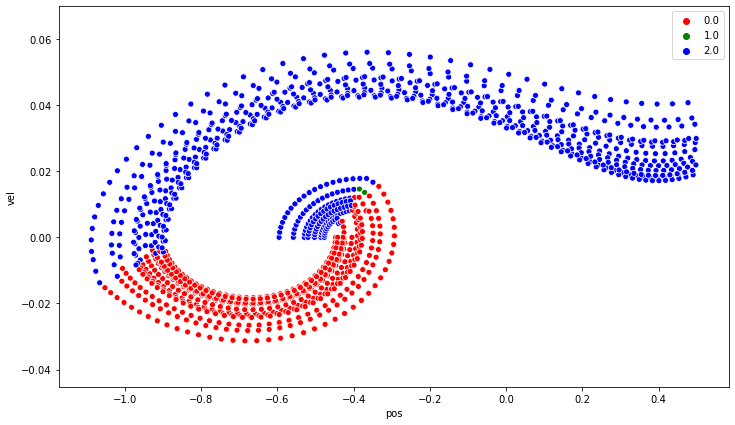

In [225]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data.pos, data.vel, hue=y_hat, palette=['red', 'green', 'blue'])

### Examine how well the learned policy performs in the enviroment

In [229]:
env = gym.make('MountainCar-v0')
sequence = np.empty((200, 2))
sequence[0] = env.reset()
i = 1
done = False
score = 0

In [230]:
import time
scores = np.empty((100,))
for j in range(100):
    sequence = np.empty((200, 2))
    sequence[0] = env.reset()
    i = 1
    done = False
    score = 0
    while not done:

        features = seq_to_feats(sequence[0:i])
        policy = int(float(crf.predict_single(features)[-1]))
        observation, reward, done, info = env.step(policy)
        sequence[i] = observation
        score += reward
#         env.render()
#         time.sleep(0.01)
        i += 1
        
    
    scores[j] = score

In [231]:
env.close()

In [232]:
print('Exepert score', -np.mean([demo[1]-demo[0] for demo in demos]))
print('CRF score', np.mean(scores))
print('The less negative number is better')

Exepert score -95.3076923076923
CRF score -120.01
The less negative number is better


### Compare with basic logistic regression

In [200]:
from sklearn.linear_model import LogisticRegression

In [242]:
model = LogisticRegression(penalty='none', multi_class='multinomial', fit_intercept=True).fit(data.drop(['action', 'reward'], axis=1), data.action)

In [243]:
scores = np.empty((100,))
for j in range(100):
    sequence = np.empty((200, 2))
    observation = env.reset().reshape(1, -1)
    done = False
    score = 0
    while not done:

        #features = seq_to_feats(sequence[0:i])
        policy = model.predict(observation).astype(int)[0]
        observation, reward, done, info = env.step(policy)
        observation = observation.reshape(1, -1)
        #sequence[i] = observation
        score += reward
#         env.render()
#         time.sleep(0.01)
        #i += 1
        
    
    scores[j] = score

In [244]:
env.close()

In [245]:
print('Exepert score', -np.mean([demo[1]-demo[0]+1 for demo in demos]))
print('CRF score', np.mean(scores))
print('The less negative number is better')

Exepert score -96.3076923076923
CRF score -135.53
The less negative number is better


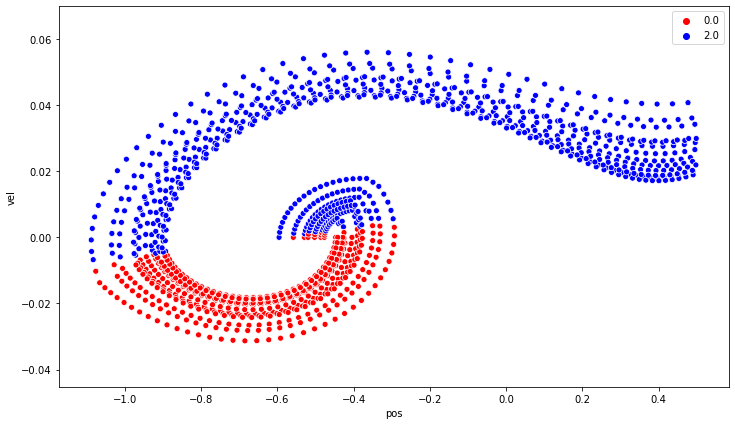

In [246]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data.pos, data.vel, hue=model.predict(data.drop(['action', 'reward'], axis=1)), palette=['red', 'blue'])